<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [3]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
#from tensorflow.keras.utils import pad_sequences
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [ ]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

In [5]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [6]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [7]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
df_reviews['Rating'].value_counts()

4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64

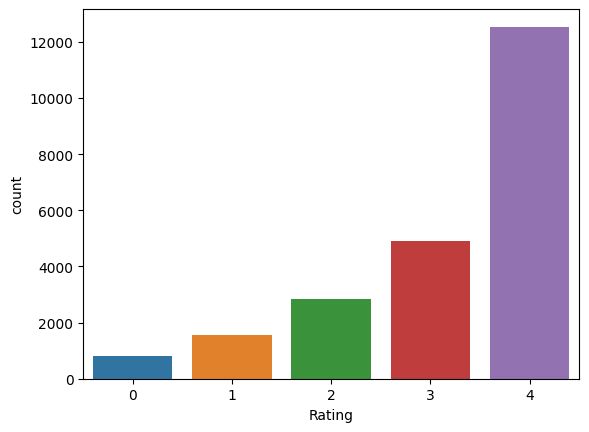

In [8]:
sns.countplot(x='Rating', data=df_reviews)
plt.show()

In [9]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['Review Text'].values
text_sequences.shape

(22641,)

In [10]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
len(text_sequences)

22641

In [11]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [12]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [13]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [14]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [15]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

In [16]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words

tok = Tokenizer(num_words)
tok.fit_on_texts(tokens)

In [17]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

14847

In [18]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [19]:
# Alumno: Determinar cual es la oración más larga
s_lenght = [len(s) for s in sequences]
print(f'el máximo es {max(s_lenght)}')

el máximo es 115


In [21]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from keras_preprocessing.sequence import pad_sequences
maxlen = 115

In [22]:
# Alumno: Observar las dimensiones de la variable input
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [23]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
y = df_reviews['Rating'].values
print(y.shape)

(22641,)


In [24]:
y[:10]

array([3, 4, 2, 4, 4, 1, 4, 3, 4, 4])

In [25]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y.reshape(-1, 1))
y = enc.fit_transform(y.reshape(-1,1)).toarray()
y[:10]


array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [26]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4242)


In [27]:
y_train[:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [28]:
# Alumno: determinar la dimensiones de entrada y salida

input_shape = X_train.shape[1] # max input sentence len
output_shape = y.shape[1]
print("in_shape", input_shape, ", out_shape", output_shape)

in_shape 115 , out_shape 5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [33]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Bidirectional
import tensorflow_addons as tfa

model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=128, input_length=input_shape))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=output_shape, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=[tfa.metrics.F1Score(num_classes=5, threshold=0.5)])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 115, 128)          256128    
                                                                 
 lstm_4 (LSTM)               (None, 115, 128)          131584    
                                                                 
 dropout_4 (Dropout)         (None, 115, 128)          0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                

In [45]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [35]:
X_train[0].shape, y_train[0].shape

((115,), (5,))

In [36]:
hist = model.fit(X_train, y_train, epochs=30, validation_split=0.2)

Epoch 1/30


2023-06-18 21:09:09.571847: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2023-06-18 21:09:10.708033: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


453/453 [==============================] - 8s 10ms/step - loss: 1.4312 - f1_score: 0.0814 - val_loss: 1.2367 - val_f1_score: 0.1402
Epoch 2/30
453/453 [==============================] - 4s 10ms/step - loss: 1.2081 - f1_score: 0.1391 - val_loss: 1.2159 - val_f1_score: 0.1429
Epoch 3/30
453/453 [==============================] - 4s 10ms/step - loss: 1.1754 - f1_score: 0.1478 - val_loss: 1.1637 - val_f1_score: 0.1498
Epoch 4/30
453/453 [==============================] - 4s 9ms/step - loss: 1.0956 - f1_score: 0.1557 - val_loss: 1.0837 - val_f1_score: 0.1549
Epoch 5/30
453/453 [==============================] - 4s 9ms/step - loss: 1.0341 - f1_score: 0.1588 - val_loss: 1.0506 - val_f1_score: 0.1590
Epoch 6/30
453/453 [==============================] - 4s 9ms/step - loss: 1.0076 - f1_score: 0.1604 - val_loss: 1.0305 - val_f1_score: 0.1598
Epoch 7/30
453/453 [==============================] - 4s 9ms/step - loss: 0.9859 - f1_score: 0.1618 - val_loss: 1.0160 - val_f1_score: 0.1608
Epoch 8/30
453

In [37]:
hist.history

{'loss': [1.4312245845794678,
  1.208114504814148,
  1.1753500699996948,
  1.0955547094345093,
  1.034149408340454,
  1.0075652599334717,
  0.9858999252319336,
  0.9696143865585327,
  0.9531481266021729,
  0.9403054118156433,
  0.9267271161079407,
  0.9154648184776306,
  0.9065870046615601,
  0.8977726697921753,
  0.8910204768180847,
  0.8829469084739685,
  0.8775205016136169,
  0.8725980520248413,
  0.8674609661102295,
  0.8628206849098206,
  0.8578926920890808,
  0.853530764579773,
  0.8501153588294983,
  0.8471486568450928,
  0.8428289294242859,
  0.8379550576210022,
  0.8370458483695984,
  0.8330886363983154,
  0.8307080268859863,
  0.8269308805465698],
 'f1_score': [array([0.       , 0.       , 0.       , 0.       , 0.4071732],
        dtype=float32),
  array([0.       , 0.       , 0.       , 0.       , 0.6955339],
        dtype=float32),
  array([0.       , 0.       , 0.       , 0.       , 0.7389705],
        dtype=float32),
  array([0.       , 0.       , 0.       , 0.       , 0.

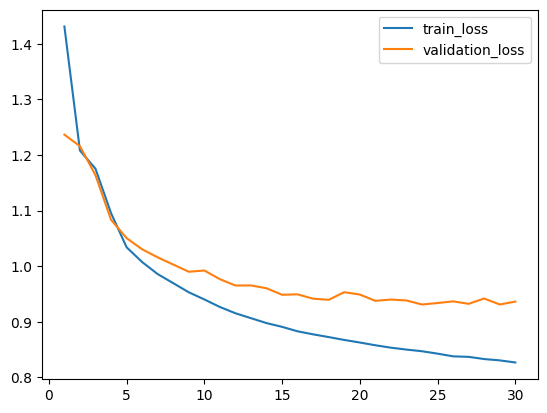

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train_loss')
sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='validation_loss')
plt.show()

In [39]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 1s 4ms/step - loss: 0.9077 - f1_score: 0.1759


[0.9076624512672424,
 array([0.        , 0.        , 0.01401051, 0.03943662, 0.8261605 ],
       dtype=float32)]

In [40]:
test_texts = tok.sequences_to_texts(X_test)

In [41]:
preds = model.predict(X_test)

In [42]:
for i, (text, rating, pred) in enumerate(zip(test_texts, y_test, preds)):
  if i > 20:
    break
  print(f'{text}\n{rating}, {np.argmax(rating)} - {pred}, {np.argmax(pred)}\n\n')

 for reference i'm 5'3 and weigh 110 lbs and i purchased a size 2 but i think atoo and there is the perfect amount of swing and it's a great length i can't say enough about it i think it's worth the price which i have to i was hesitant about so comfortable and versatile i see it being worn quite often 
[0. 0. 0. 0. 1.], 4 - [1.3056520e-07 1.8655830e-06 3.1568332e-05 1.4807392e-02 9.8515910e-01], 4


i saw this dress in my local retailer store and am not sure why i did not try it on then but later at home it to me i loved the colored embroidery against the black my husband and i will be to later this fall and i wanted to take a dress with me that wouldn't take up too much room and be for times when i wanted to dress up a little online i saw that it was available in the petite and with the reviews that it ran large i opted for a medium petite
[0. 0. 0. 0. 1.], 4 - [0.03450345 0.07028161 0.17606239 0.3656908  0.3534618 ], 3


i was tempted to get this online but just wasn't sure i wanted 